## Textual Vector Embedding

We will explore the Glove textual vector embedding [[PSM14]](#pennington14glove-global) which will be used in the following part to describe each word in a corpus for the purpose of image captioning.

We will use the FlickR8k image dataset ([http://nlp.cs.illinois.edu/HockenmaierGroup/8k-pictures.html](http://nlp.cs.illinois.edu/HockenmaierGroup/8k-pictures.html)), where each image is associated with 5 different captions that describe its content in natural language.

We will start by downloading the file that contains the captions of the Flickr 8k image dataset. The training set contains 6000 images, which corresponds to 30000 captions.


### **a) Extraction of Glove Embeddings from Captions**

We will extract the Glove vector embeddings from the captions in the Glove dataset.
We will use the following code to retrieve all the words present:


In [3]:
import pandas as pd

filename = 'data/flickr_8k_train_dataset.txt'
df = pd.read_csv(filename, delimiter='\t')
nb_samples = df.shape[0]
iter = df.iterrows()
allwords = []
for i in range(nb_samples):
    x = iter.__next__()
    cap_words = x[1][1].split()
    cap_wordsl = [w.lower() for w in cap_words]
    allwords.extend(cap_wordsl)

unique = list(set(allwords)) # List of different words in captions
print("There is ", len(unique), " different words in the caption data base")

There is  7707  different words in the caption data base


We will now download the file containing the Glove vector embeddings, which is available on Drive: https://drive.google.com/drive/u/0/folders/1KhSGBTYE5yopfqtCiDjDoZA3KF7PYYSv?fbclid=IwZXh0bgNhZW0CMTAAAR0bRikxA9ejc6OhNZmR4tINwflRpCyFfWaBP4DPNNwgUS-JOEU33fijenE_aem_AWCac0Lr6WkHXj1g8rHyPDSVQ580elp3Pca8vcWgcFzSww7HteB4QcS9iWUbsXAO1BRcIM_ltlUZMeTGDE1WcsQX


In [4]:
path = "data/" # path à renseigner après téléchargement
GLOVE_MODEL = path + "glove.6B.100d.txt"
fglove = open(GLOVE_MODEL, "r", encoding='utf8')

We will determine the list of words present in the captions and in the Glove file.


In [5]:
import numpy as np

cpt=0
listwords=[]
listembeddings=[]
for line in fglove:
    row = line.strip().split()
    word = row[0]
    if(word in unique or word=='unk'):
        listwords.append(word)
        embedding = row[1:]
        listembeddings.append(embedding)
        cpt +=1
        print("word: " + word + " embedded " + str(cpt))

fglove.close()
nbwords = len(listembeddings)
tembedding = len(listembeddings[0])
print("Number of words = " + str(len(listembeddings)) + " Embedding size = " + str(tembedding))

word: the embedded 1
word: , embedded 2
word: . embedded 3
word: of embedded 4
word: to embedded 5
word: and embedded 6
word: in embedded 7
word: a embedded 8
word: " embedded 9
word: 's embedded 10
word: for embedded 11
word: - embedded 12
word: that embedded 13
word: on embedded 14
word: is embedded 15
word: was embedded 16
word: with embedded 17
word: he embedded 18
word: as embedded 19
word: it embedded 20
word: by embedded 21
word: at embedded 22
word: ( embedded 23
word: ) embedded 24
word: from embedded 25
word: his embedded 26
word: an embedded 27
word: be embedded 28
word: has embedded 29
word: are embedded 30
word: have embedded 31
word: but embedded 32
word: were embedded 33
word: not embedded 34
word: this embedded 35
word: who embedded 36
word: they embedded 37
word: had embedded 38
word: i embedded 39
word: which embedded 40
word: will embedded 41
word: their embedded 42
word: : embedded 43
word: or embedded 44
word: its embedded 45
word: one embedded 46
word: after embed

**N.B.:** We have added the word “unk” which is intended to encode words in the captions that are absent from the embedding file.

We will finally create the embedding matrix, adding two words to encode the words “start” and “end”:


In [6]:
embeddings = np.zeros((len(listembeddings)+2,tembedding+2))
for i in range(nbwords):
    embeddings[i,0:tembedding] = listembeddings[i]
listwords.append('<start>')
embeddings[7001,100] = 1
listwords.append('<end>')
embeddings[7002,101] = 1

In [7]:
print(embeddings.shape)

(7003, 102)


The embedding matrix contains all the words found in the imported file, totaling 7001, to which we have added the words 'start' and 'end'. Each word is encoded on 100 variables, with an additional new row specifying if the word is 'start' and another for 'end'. Thus, we have 7003 words and 102 different embeddings, resulting in dimensions of (7003, 102).


And save the list of words and the associated vectors:


In [8]:
import _pickle as pickle

outfile = 'Caption_Embeddings.p'
with open(outfile, "wb") as pickle_f:
    pickle.dump([listwords, embeddings], pickle_f)

### **b) Analysis of Glove Embeddings from Captions**

We will start by opening the embeddings file, then normalizing the vectors so that they have a unit Euclidean norm:


In [9]:
import numpy as np
import _pickle as pickle
from sklearn.preprocessing import normalize

outfile = './data/Caption_Embeddings.p'
[listwords, embeddings] = pickle.load( open( outfile, "rb" ) )
print("embeddings: "+str(embeddings.shape))

for i in range(embeddings.shape[0]):
    v = embeddings[i]
    embeddings[i] = normalize(v[:,np.newaxis], axis=0).ravel()

embeddings: (7003, 102)


We will now perform clustering in the embedding space into 10 groups using the KMeans algorithm: [https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).


In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init='random', max_iter=1000).fit(embeddings)
clustersID  = kmeans.labels_
clusters = kmeans.cluster_centers_

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


We display the point closest to each center, as well as the next 20 points closest to the center:


In [11]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

pointsclusters = np.zeros((10,2))
indclusters = [[], [], [], [], [], [], [], [], [], []]

for i in range(10):
    norm = np.linalg.norm((clusters[i] - embeddings),axis=1)
    inorms = np.argsort(norm)
    indclusters[i][:] = inorms[:]
    print("Cluster "+str(i)+" ="+listwords[indclusters[i][0]])
    for j in range(1,21):
        print(" mot: "+listwords[indclusters[i][j]])

Cluster 0 =plastic
 mot: cream
 mot: cake
 mot: bread
 mot: bags
 mot: bag
 mot: cans
 mot: vegetables
 mot: fruit
 mot: butter
 mot: baked
 mot: bottle
 mot: chicken
 mot: soup
 mot: filled
 mot: soft
 mot: chocolate
 mot: dried
 mot: coffee
 mot: stuffed
 mot: candy
Cluster 1 =poking
 mot: lazily
 mot: playfully
 mot: flinging
 mot: crawling
 mot: peeking
 mot: rubbing
 mot: crazily
 mot: splashing
 mot: zipping
 mot: nibbling
 mot: bouncing
 mot: gazes
 mot: tugging
 mot: gazing
 mot: squinting
 mot: peering
 mot: gazed
 mot: tossing
 mot: ducking
 mot: giggling
Cluster 2 =vehicle
 mot: car
 mot: off
 mot: train
 mot: carrying
 mot: truck
 mot: onto
 mot: cars
 mot: bus
 mot: away
 mot: vehicles
 mot: fire
 mot: into
 mot: boat
 mot: along
 mot: plane
 mot: traffic
 mot: inside
 mot: down
 mot: driving
 mot: around
Cluster 3 =trousers
 mot: embroidered
 mot: sleeves
 mot: pants
 mot: leggings
 mot: multicolored
 mot: jacket
 mot: worn
 mot: blouse
 mot: sweater
 mot: oversized
 mot:

To visualize the distribution of points in the embedding space, we use the t-SNE method:


In [12]:
tsne = TSNE(n_components=2, perplexity=30, verbose=2, init='pca', early_exaggeration=24)
points2D = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7003 samples in 0.001s...
[t-SNE] Computed neighbors for 7003 samples in 0.417s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7003
[t-SNE] Computed conditional probabilities for sample 2000 / 7003
[t-SNE] Computed conditional probabilities for sample 3000 / 7003
[t-SNE] Computed conditional probabilities for sample 4000 / 7003
[t-SNE] Computed conditional probabilities for sample 5000 / 7003
[t-SNE] Computed conditional probabilities for sample 6000 / 7003
[t-SNE] Computed conditional probabilities for sample 7000 / 7003
[t-SNE] Computed conditional probabilities for sample 7003 / 7003
[t-SNE] Mean sigma: 0.311792
[t-SNE] Computed conditional probabilities in 0.187s
[t-SNE] Iteration 50: error = 201.0184326, gradient norm = 0.0000000 (50 iterations in 1.430s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 201.018433
[t-SNE] Iteration 10

C:\Users\lehbna23\AppData\Local\Temp\ipykernel_11484\3083299239.py:9: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pointsclusters[:,0], pointsclusters[:,1], c=range(10), marker = '+', s=1000, edgecolors='none', cmap=cmap, alpha=1.0)


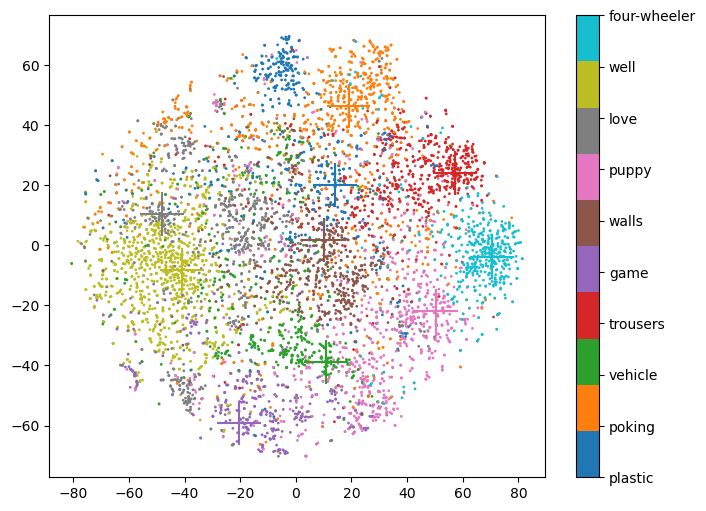

In [13]:
for i in range(10):
    pointsclusters[i,:] = points2D[int(indclusters[i][0])]

cmap =cm.tab10
plt.figure(figsize=(8,6), dpi=100)
plt.set_cmap(cmap)
plt.subplots_adjust(hspace=0.4)
plt.scatter(points2D[:,0], points2D[:,1], c=clustersID,  s=4 ,edgecolors='none', cmap=cmap, alpha=1.0)
plt.scatter(pointsclusters[:,0], pointsclusters[:,1], c=range(10), marker = '+', s=1000, edgecolors='none', cmap=cmap, alpha=1.0)

cbar = plt.colorbar(ticks=range(10))
cbar.set_ticklabels([listwords[indclusters[i][0]] for i in range(10)])
plt.show()



***

<a id='pennington14glove-global'></a>
\[PSM14\] Jeffrey Pennington, Richard Socher, and Christopher D. Manning. Glove: global vectors for word representation. *In EMNLP*. 2014.